## Live Demo

In [ ]:
# %pip install tensorflow
# %pip install Pillow
# %pip install matplotlib
# %pip install opencv-python
# %pip install vonage
# %pip install python-dotenv

import sys
import os
import warnings
# import logging

# logging.basicConfig(level=logging.DEBUG)

os.environ['TF_CPP_MIN_LOG_LEVEL'] = '3'
warnings.filterwarnings('ignore')  # <-- Comment out or remove this line

class DevNull:
    def write(self, msg): pass
    def flush(self): pass

sys.stderr = DevNull()      # Ignore Python warnings (remove or comment out)

# os.environ['TF_CPP_MIN_LOG_LEVEL'] = '0'  # Show all TensorFlow logs
# warnings.filterwarnings('default')        # Show all warnings

# # Restore sys.stderr to default if it was redirected
# if hasattr(sys, '__stderr__'):
#     sys.stderr = sys.__stderr__

In [ ]:
import cv2
from PIL import Image
from fall_prediction import Fall_prediction
import matplotlib.pyplot as plt
import requests
import datetime
from dotenv import load_dotenv
import os

load_dotenv()

cap = cv2.VideoCapture(0)  # 0 = default webcam

frame_buffer = []
previous_record_time = None

while True:
    ret, frame = cap.read()

    if not ret:
        break
    
    # Convert OpenCV BGR image to PIL Image
    pil_img = Image.fromarray(cv2.cvtColor(frame, cv2.COLOR_BGR2RGB))
    frame_buffer.append({
        'img': pil_img,
        'record_time': datetime.datetime.now()
    })

    # Keep only the last 3 frames
    if len(frame_buffer) > 3:
        frame_buffer.pop(0)

    # Run prediction when we have 3 frames
    if len(frame_buffer) == 3:
        fig = plt.figure(figsize=(12,12))
        for idx, item in enumerate(frame_buffer):
            no = idx+1
            fig.add_subplot(1, 3, no)
            plt.imshow(item['img'])
            plt.title(item['record_time'], fontsize=8)
            plt.axis("off")
        plt.show()

        img_list = [item['img'] for item in frame_buffer]
        response = Fall_prediction(*img_list)
        if response:
            print("There is", response['category'])
            print("Confidence :", response['confidence'])
            print("Angle :", response['angle'])
            print("Keypoint_corr :", response['keypoint_corr'])

            # Call /record_fall API
            try:
                api_response = requests.post(
                    f"{os.getenv('SIGNAL_SERVER_URL')}/record_fall",
                    json={
                        "source": "camera",
                        "patient_id": 1,
                        "detected_at": datetime.datetime.now().isoformat()
                    }
                )
                print("API response:", api_response.json())
            except Exception as e:
                print("Failed to call /record_fall:", e)
        else:
            print("There is no fall detection...")

cap.release()
cv2.destroyAllWindows()

Starting camera capture...
Waiting for frames...
Waiting for frames...
Waiting for frames...
Time before plotting: 2025-06-10 23:37:32.580798


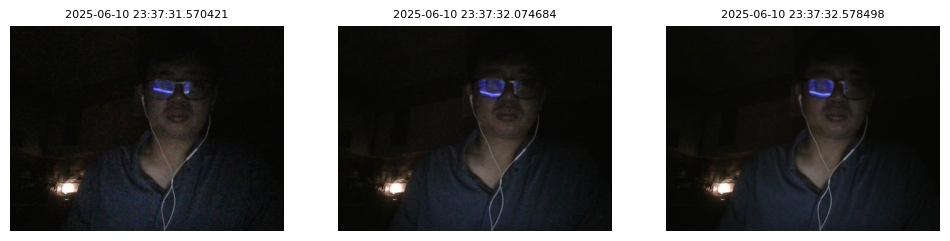

DEBUG:src.pipeline.inference:EdgeTPU init error: FileNotFoundError("Could not find module 'libedgetpu.so.1.0' (or one of its dependencies). Try using the full path with constructor syntax.")
DEBUG:src.pipeline.inference:EdgeTPU not available. Will use TFLite CPU runtime.
DEBUG:src.pipeline.pose_base:Initializing PoseEngine with confidence threshold             0.6
DEBUG:src.pipeline.fall_detect:Initializing FallDetector with conficence threshold:                   0.6
DEBUG:src.pipeline.fall_detect:FallDetector received new sample
DEBUG:src.pipeline.fall_detect:Calling TF engine for inference
DEBUG:src.pipeline.pose_base:input image size = (640, 480)
DEBUG:src.pipeline.pose_base:thmubnail image size = (257, 193)
DEBUG:src.pipeline.pose_base:input image size = (257, 193)
DEBUG:src.pipeline.pose_base:new image size = (257, 257)
DEBUG:src.pipeline.pose_engine:Overall pose score (keypoint score average): 0.29411764705882354
DEBUG:src.pipeline.pose_engine:Detected a pose with 5 keypoints th

Time after plotting: 2025-06-10 23:37:32.690083
Time before detecting: %s 2025-06-10 23:37:32.705057


DEBUG:src.pipeline.pose_base:new image size = (257, 257)
DEBUG:src.pipeline.pose_engine:Overall pose score (keypoint score average): 0.0
DEBUG:src.pipeline.fall_detect:Estimated spinal vector score: 0
DEBUG:src.pipeline.fall_detect:No pose detected or detection score does not meet                     confidence threshold of 0.6.
DEBUG:src.pipeline.fall_detect:thumbnail: <PIL.Image.Image image mode=RGB size=257x193 at 0x1AF0BB7FF90>
DEBUG:src.pipeline.fall_detect:FallDetector received new sample
DEBUG:src.pipeline.fall_detect:Calling TF engine for inference
DEBUG:src.pipeline.pose_base:input image size = (640, 480)
DEBUG:src.pipeline.pose_base:thmubnail image size = (257, 193)
DEBUG:src.pipeline.pose_base:input image size = (257, 193)
DEBUG:src.pipeline.pose_base:new image size = (257, 257)
DEBUG:src.pipeline.pose_engine:Overall pose score (keypoint score average): 0.35294117647058826
DEBUG:src.pipeline.pose_engine:Detected a pose with 6 keypoints that score over                 the min

Time after detecting: %s 2025-06-10 23:37:32.791463
Time before detecting: %s 2025-06-10 23:37:32.792654


DEBUG:src.pipeline.pose_engine:Detected a pose with 3 keypoints that score over                 the minimum confidence threshold of                 0.6.
DEBUG:src.pipeline.pose_engine:Debug image saved: tmp-pose-detect-image-time-1505809125-keypoints-3.jpg
DEBUG:src.pipeline.fall_detect:Estimated spinal vector score: 0
DEBUG:src.pipeline.pose_base:input image size = (480, 640)
DEBUG:src.pipeline.pose_base:thmubnail image size = (193, 257)
DEBUG:src.pipeline.pose_base:input image size = (193, 257)
DEBUG:src.pipeline.pose_base:new image size = (257, 257)
DEBUG:src.pipeline.pose_engine:Overall pose score (keypoint score average): 0.0
DEBUG:src.pipeline.fall_detect:Estimated spinal vector score: 0
DEBUG:src.pipeline.fall_detect:No pose detected or detection score does not meet                     confidence threshold of 0.6.
DEBUG:src.pipeline.fall_detect:thumbnail: <PIL.Image.Image image mode=RGB size=257x193 at 0x1AF0BDA5A10>
DEBUG:src.pipeline.fall_detect:FallDetector received new sampl

Time after detecting: %s 2025-06-10 23:37:32.919226
Time before detecting: %s 2025-06-10 23:37:32.920223


DEBUG:src.pipeline.pose_base:input image size = (193, 257)
DEBUG:src.pipeline.pose_base:new image size = (257, 257)
DEBUG:src.pipeline.pose_engine:Overall pose score (keypoint score average): 0.058823529411764705
DEBUG:src.pipeline.pose_engine:Detected a pose with 1 keypoints that score over                 the minimum confidence threshold of                 0.6.
DEBUG:src.pipeline.pose_engine:Debug image saved: tmp-pose-detect-image-time-1505809234-keypoints-1.jpg
DEBUG:src.pipeline.fall_detect:Estimated spinal vector score: 0
DEBUG:src.pipeline.fall_detect:No pose detected or detection score does not meet                     confidence threshold of 0.6.
DEBUG:src.pipeline.fall_detect:thumbnail: <PIL.Image.Image image mode=RGB size=257x193 at 0x1AF0BDA0F50>


Time after detecting: %s 2025-06-10 23:37:32.993858
Time after predicting: 2025-06-10 23:37:32.996468
There is no fall detection...
Waiting for frames...
Time before plotting: 2025-06-10 23:37:33.085064


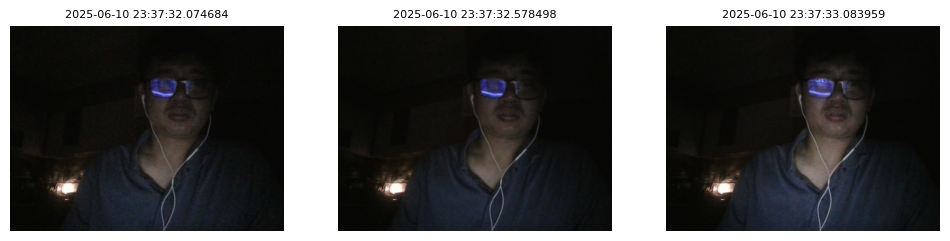

DEBUG:src.pipeline.inference:EdgeTPU init error: FileNotFoundError("Could not find module 'libedgetpu.so.1.0' (or one of its dependencies). Try using the full path with constructor syntax.")
DEBUG:src.pipeline.inference:EdgeTPU not available. Will use TFLite CPU runtime.
DEBUG:src.pipeline.pose_base:Initializing PoseEngine with confidence threshold             0.6
DEBUG:src.pipeline.fall_detect:Initializing FallDetector with conficence threshold:                   0.6
DEBUG:src.pipeline.fall_detect:FallDetector received new sample
DEBUG:src.pipeline.fall_detect:Calling TF engine for inference
DEBUG:src.pipeline.pose_base:input image size = (640, 480)
DEBUG:src.pipeline.pose_base:thmubnail image size = (257, 193)
DEBUG:src.pipeline.pose_base:input image size = (257, 193)
DEBUG:src.pipeline.pose_base:new image size = (257, 257)
DEBUG:src.pipeline.pose_engine:Overall pose score (keypoint score average): 0.35294117647058826
DEBUG:src.pipeline.pose_engine:Detected a pose with 6 keypoints th

Time after plotting: 2025-06-10 23:37:33.198099
Time before detecting: %s 2025-06-10 23:37:33.212142
Time after detecting: %s 2025-06-10 23:37:33.284632
Time before detecting: %s 2025-06-10 23:37:33.285853
Time after detecting: %s 2025-06-10 23:37:33.358895
Time before detecting: %s 2025-06-10 23:37:33.358895


DEBUG:src.pipeline.pose_engine:Detected a pose with 6 keypoints that score over                 the minimum confidence threshold of                 0.6.
DEBUG:src.pipeline.pose_engine:Debug image saved: tmp-pose-detect-image-time-1505809625-keypoints-6.jpg
DEBUG:src.pipeline.fall_detect:Estimated spinal vector score: 0
DEBUG:src.pipeline.pose_base:input image size = (480, 640)
DEBUG:src.pipeline.pose_base:thmubnail image size = (193, 257)
DEBUG:src.pipeline.pose_base:input image size = (193, 257)
DEBUG:src.pipeline.pose_base:new image size = (257, 257)
DEBUG:src.pipeline.pose_engine:Overall pose score (keypoint score average): 0.17647058823529413
DEBUG:src.pipeline.pose_engine:Detected a pose with 3 keypoints that score over                 the minimum confidence threshold of                 0.6.
DEBUG:src.pipeline.pose_engine:Debug image saved: tmp-pose-detect-image-time-1505809640-keypoints-3.jpg
DEBUG:src.pipeline.fall_detect:Estimated spinal vector score: 0
DEBUG:src.pipeline.pose_

Time after detecting: %s 2025-06-10 23:37:33.433940
Time after predicting: 2025-06-10 23:37:33.435316
There is no fall detection...
Waiting for frames...
Time before plotting: 2025-06-10 23:37:33.589610


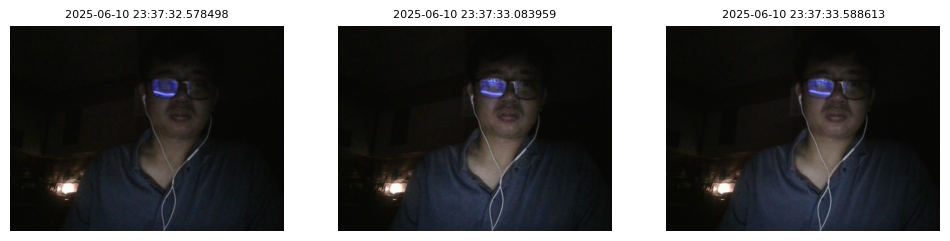

DEBUG:src.pipeline.inference:EdgeTPU init error: FileNotFoundError("Could not find module 'libedgetpu.so.1.0' (or one of its dependencies). Try using the full path with constructor syntax.")
DEBUG:src.pipeline.inference:EdgeTPU not available. Will use TFLite CPU runtime.
DEBUG:src.pipeline.pose_base:Initializing PoseEngine with confidence threshold             0.6
DEBUG:src.pipeline.fall_detect:Initializing FallDetector with conficence threshold:                   0.6
DEBUG:src.pipeline.fall_detect:FallDetector received new sample
DEBUG:src.pipeline.fall_detect:Calling TF engine for inference
DEBUG:src.pipeline.pose_base:input image size = (640, 480)
DEBUG:src.pipeline.pose_base:thmubnail image size = (257, 193)
DEBUG:src.pipeline.pose_base:input image size = (257, 193)
DEBUG:src.pipeline.pose_base:new image size = (257, 257)
DEBUG:src.pipeline.pose_engine:Overall pose score (keypoint score average): 0.4117647058823529
DEBUG:src.pipeline.pose_engine:Detected a pose with 7 keypoints tha

Time after plotting: 2025-06-10 23:37:33.702788
Time before detecting: %s 2025-06-10 23:37:33.716258
Time after detecting: %s 2025-06-10 23:37:33.788592
Time before detecting: %s 2025-06-10 23:37:33.789666
Time after detecting: %s 2025-06-10 23:37:33.862212
Time before detecting: %s 2025-06-10 23:37:33.862212


DEBUG:src.pipeline.pose_engine:Detected a pose with 7 keypoints that score over                 the minimum confidence threshold of                 0.6.
DEBUG:src.pipeline.pose_engine:Debug image saved: tmp-pose-detect-image-time-1505810125-keypoints-7.jpg
DEBUG:src.pipeline.fall_detect:Estimated spinal vector score: 0
DEBUG:src.pipeline.pose_base:input image size = (480, 640)
DEBUG:src.pipeline.pose_base:thmubnail image size = (193, 257)
DEBUG:src.pipeline.pose_base:input image size = (193, 257)
DEBUG:src.pipeline.pose_base:new image size = (257, 257)
DEBUG:src.pipeline.pose_engine:Overall pose score (keypoint score average): 0.23529411764705882
DEBUG:src.pipeline.pose_engine:Detected a pose with 4 keypoints that score over                 the minimum confidence threshold of                 0.6.
DEBUG:src.pipeline.pose_engine:Debug image saved: tmp-pose-detect-image-time-1505810156-keypoints-4.jpg
DEBUG:src.pipeline.fall_detect:Estimated spinal vector score: 0
DEBUG:src.pipeline.pose_

Time after detecting: %s 2025-06-10 23:37:33.936969
Time after predicting: 2025-06-10 23:37:33.937985
There is no fall detection...
Waiting for frames...
Time before plotting: 2025-06-10 23:37:34.092080


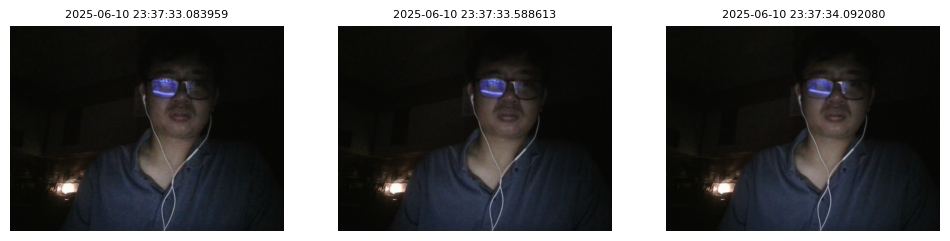

DEBUG:src.pipeline.inference:EdgeTPU init error: FileNotFoundError("Could not find module 'libedgetpu.so.1.0' (or one of its dependencies). Try using the full path with constructor syntax.")
DEBUG:src.pipeline.inference:EdgeTPU not available. Will use TFLite CPU runtime.
DEBUG:src.pipeline.pose_base:Initializing PoseEngine with confidence threshold             0.6
DEBUG:src.pipeline.fall_detect:Initializing FallDetector with conficence threshold:                   0.6
DEBUG:src.pipeline.fall_detect:FallDetector received new sample
DEBUG:src.pipeline.fall_detect:Calling TF engine for inference
DEBUG:src.pipeline.pose_base:input image size = (640, 480)
DEBUG:src.pipeline.pose_base:thmubnail image size = (257, 193)
DEBUG:src.pipeline.pose_base:input image size = (257, 193)
DEBUG:src.pipeline.pose_base:new image size = (257, 257)
DEBUG:src.pipeline.pose_engine:Overall pose score (keypoint score average): 0.35294117647058826
DEBUG:src.pipeline.pose_engine:Detected a pose with 6 keypoints th

Time after plotting: 2025-06-10 23:37:34.248161
Time before detecting: %s 2025-06-10 23:37:34.260280
Time after detecting: %s 2025-06-10 23:37:34.341791
Time before detecting: %s 2025-06-10 23:37:34.343727
Time after detecting: %s 2025-06-10 23:37:34.418689
Time before detecting: %s 2025-06-10 23:37:34.419792


DEBUG:src.pipeline.pose_engine:Detected a pose with 7 keypoints that score over                 the minimum confidence threshold of                 0.6.
DEBUG:src.pipeline.pose_engine:Debug image saved: tmp-pose-detect-image-time-1505810671-keypoints-7.jpg
DEBUG:src.pipeline.fall_detect:Estimated spinal vector score: 0
DEBUG:src.pipeline.pose_base:input image size = (480, 640)
DEBUG:src.pipeline.pose_base:thmubnail image size = (193, 257)
DEBUG:src.pipeline.pose_base:input image size = (193, 257)
DEBUG:src.pipeline.pose_base:new image size = (257, 257)
DEBUG:src.pipeline.pose_engine:Overall pose score (keypoint score average): 0.17647058823529413
DEBUG:src.pipeline.pose_engine:Detected a pose with 3 keypoints that score over                 the minimum confidence threshold of                 0.6.
DEBUG:src.pipeline.pose_engine:Debug image saved: tmp-pose-detect-image-time-1505810703-keypoints-3.jpg
DEBUG:src.pipeline.fall_detect:Estimated spinal vector score: 0
DEBUG:src.pipeline.pose_

Time after detecting: %s 2025-06-10 23:37:34.500667
Time after predicting: 2025-06-10 23:37:34.502892
There is no fall detection...
Waiting for frames...
Time before plotting: 2025-06-10 23:37:34.597531


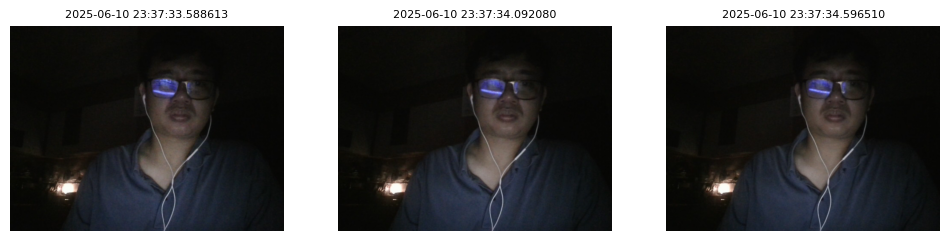

DEBUG:src.pipeline.inference:EdgeTPU init error: FileNotFoundError("Could not find module 'libedgetpu.so.1.0' (or one of its dependencies). Try using the full path with constructor syntax.")
DEBUG:src.pipeline.inference:EdgeTPU not available. Will use TFLite CPU runtime.
DEBUG:src.pipeline.pose_base:Initializing PoseEngine with confidence threshold             0.6
DEBUG:src.pipeline.fall_detect:Initializing FallDetector with conficence threshold:                   0.6
DEBUG:src.pipeline.fall_detect:FallDetector received new sample
DEBUG:src.pipeline.fall_detect:Calling TF engine for inference
DEBUG:src.pipeline.pose_base:input image size = (640, 480)
DEBUG:src.pipeline.pose_base:thmubnail image size = (257, 193)
DEBUG:src.pipeline.pose_base:input image size = (257, 193)
DEBUG:src.pipeline.pose_base:new image size = (257, 257)
DEBUG:src.pipeline.pose_engine:Overall pose score (keypoint score average): 0.4117647058823529
DEBUG:src.pipeline.pose_engine:Detected a pose with 7 keypoints tha

Time after plotting: 2025-06-10 23:37:34.702151
Time before detecting: %s 2025-06-10 23:37:34.721033
Time after detecting: %s 2025-06-10 23:37:34.802620
Time before detecting: %s 2025-06-10 23:37:34.803616
Time after detecting: %s 2025-06-10 23:37:34.873762
Time before detecting: %s 2025-06-10 23:37:34.874949


DEBUG:src.pipeline.pose_engine:Overall pose score (keypoint score average): 0.4117647058823529
DEBUG:src.pipeline.pose_engine:Detected a pose with 7 keypoints that score over                 the minimum confidence threshold of                 0.6.
DEBUG:src.pipeline.pose_engine:Debug image saved: tmp-pose-detect-image-time-1505811140-keypoints-7.jpg
DEBUG:src.pipeline.fall_detect:Estimated spinal vector score: 0
DEBUG:src.pipeline.pose_base:input image size = (480, 640)
DEBUG:src.pipeline.pose_base:thmubnail image size = (193, 257)
DEBUG:src.pipeline.pose_base:input image size = (193, 257)
DEBUG:src.pipeline.pose_base:new image size = (257, 257)
DEBUG:src.pipeline.pose_engine:Overall pose score (keypoint score average): 0.17647058823529413
DEBUG:src.pipeline.pose_engine:Detected a pose with 3 keypoints that score over                 the minimum confidence threshold of                 0.6.
DEBUG:src.pipeline.pose_engine:Debug image saved: tmp-pose-detect-image-time-1505811171-keypoints

Time after detecting: %s 2025-06-10 23:37:34.954457
Time after predicting: 2025-06-10 23:37:34.956494
There is no fall detection...
Waiting for frames...
Time before plotting: 2025-06-10 23:37:35.100619


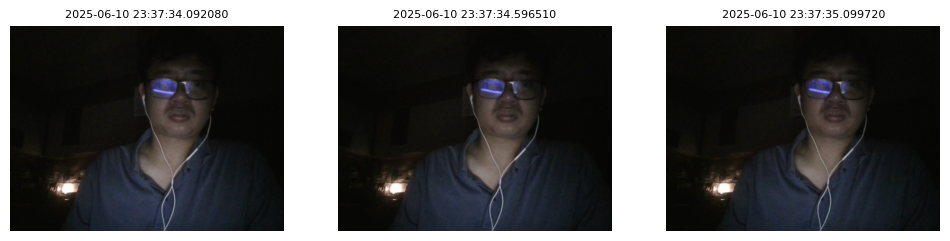

DEBUG:src.pipeline.inference:EdgeTPU init error: FileNotFoundError("Could not find module 'libedgetpu.so.1.0' (or one of its dependencies). Try using the full path with constructor syntax.")
DEBUG:src.pipeline.inference:EdgeTPU not available. Will use TFLite CPU runtime.
DEBUG:src.pipeline.pose_base:Initializing PoseEngine with confidence threshold             0.6
DEBUG:src.pipeline.fall_detect:Initializing FallDetector with conficence threshold:                   0.6
DEBUG:src.pipeline.fall_detect:FallDetector received new sample
DEBUG:src.pipeline.fall_detect:Calling TF engine for inference
DEBUG:src.pipeline.pose_base:input image size = (640, 480)
DEBUG:src.pipeline.pose_base:thmubnail image size = (257, 193)
DEBUG:src.pipeline.pose_base:input image size = (257, 193)
DEBUG:src.pipeline.pose_base:new image size = (257, 257)
DEBUG:src.pipeline.pose_engine:Overall pose score (keypoint score average): 0.4117647058823529
DEBUG:src.pipeline.pose_engine:Detected a pose with 7 keypoints tha

Time after plotting: 2025-06-10 23:37:35.366951
Time before detecting: %s 2025-06-10 23:37:35.380816
Time after detecting: %s 2025-06-10 23:37:35.466064
Time before detecting: %s 2025-06-10 23:37:35.466064
Time after detecting: %s 2025-06-10 23:37:35.538241
Time before detecting: %s 2025-06-10 23:37:35.538241


DEBUG:src.pipeline.pose_engine:Overall pose score (keypoint score average): 0.4117647058823529
DEBUG:src.pipeline.pose_engine:Detected a pose with 7 keypoints that score over                 the minimum confidence threshold of                 0.6.
DEBUG:src.pipeline.pose_engine:Debug image saved: tmp-pose-detect-image-time-1505811796-keypoints-7.jpg
DEBUG:src.pipeline.fall_detect:Estimated spinal vector score: 0
DEBUG:src.pipeline.pose_base:input image size = (480, 640)
DEBUG:src.pipeline.pose_base:thmubnail image size = (193, 257)
DEBUG:src.pipeline.pose_base:input image size = (193, 257)
DEBUG:src.pipeline.pose_base:new image size = (257, 257)
DEBUG:src.pipeline.pose_engine:Overall pose score (keypoint score average): 0.17647058823529413
DEBUG:src.pipeline.pose_engine:Detected a pose with 3 keypoints that score over                 the minimum confidence threshold of                 0.6.
DEBUG:src.pipeline.pose_engine:Debug image saved: tmp-pose-detect-image-time-1505811828-keypoints

Time after detecting: %s 2025-06-10 23:37:35.624895
Time after predicting: 2025-06-10 23:37:35.626109
There is no fall detection...
Waiting for frames...
Time before plotting: 2025-06-10 23:37:35.626109


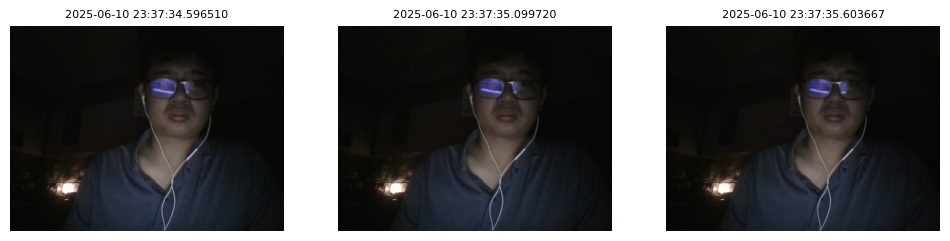

DEBUG:src.pipeline.inference:EdgeTPU init error: FileNotFoundError("Could not find module 'libedgetpu.so.1.0' (or one of its dependencies). Try using the full path with constructor syntax.")
DEBUG:src.pipeline.inference:EdgeTPU not available. Will use TFLite CPU runtime.
DEBUG:src.pipeline.pose_base:Initializing PoseEngine with confidence threshold             0.6
DEBUG:src.pipeline.fall_detect:Initializing FallDetector with conficence threshold:                   0.6
DEBUG:src.pipeline.fall_detect:FallDetector received new sample
DEBUG:src.pipeline.fall_detect:Calling TF engine for inference
DEBUG:src.pipeline.pose_base:input image size = (640, 480)
DEBUG:src.pipeline.pose_base:thmubnail image size = (257, 193)
DEBUG:src.pipeline.pose_base:input image size = (257, 193)
DEBUG:src.pipeline.pose_base:new image size = (257, 257)
DEBUG:src.pipeline.pose_engine:Overall pose score (keypoint score average): 0.4117647058823529
DEBUG:src.pipeline.pose_engine:Detected a pose with 7 keypoints tha

Time after plotting: 2025-06-10 23:37:35.744605
Time before detecting: %s 2025-06-10 23:37:35.757955


DEBUG:src.pipeline.pose_engine:Detected a pose with 3 keypoints that score over                 the minimum confidence threshold of                 0.6.
DEBUG:src.pipeline.pose_engine:Debug image saved: tmp-pose-detect-image-time-1505812062-keypoints-3.jpg
DEBUG:src.pipeline.fall_detect:Estimated spinal vector score: 0
DEBUG:src.pipeline.pose_base:input image size = (480, 640)
DEBUG:src.pipeline.pose_base:thmubnail image size = (193, 257)
DEBUG:src.pipeline.pose_base:input image size = (193, 257)
DEBUG:src.pipeline.pose_base:new image size = (257, 257)
DEBUG:src.pipeline.pose_engine:Overall pose score (keypoint score average): 0.11764705882352941
DEBUG:src.pipeline.pose_engine:Detected a pose with 2 keypoints that score over                 the minimum confidence threshold of                 0.6.
DEBUG:src.pipeline.pose_engine:Debug image saved: tmp-pose-detect-image-time-1505812093-keypoints-2.jpg
DEBUG:src.pipeline.fall_detect:Estimated spinal vector score: 0
DEBUG:src.pipeline.fall_

Time after detecting: %s 2025-06-10 23:37:35.855378
Time before detecting: %s 2025-06-10 23:37:35.856380


DEBUG:src.pipeline.pose_engine:Detected a pose with 2 keypoints that score over                 the minimum confidence threshold of                 0.6.
DEBUG:src.pipeline.pose_engine:Debug image saved: tmp-pose-detect-image-time-1505812171-keypoints-2.jpg
DEBUG:src.pipeline.fall_detect:Estimated spinal vector score: 0
DEBUG:src.pipeline.fall_detect:No pose detected or detection score does not meet                     confidence threshold of 0.6.
DEBUG:src.pipeline.fall_detect:thumbnail: <PIL.Image.Image image mode=RGB size=257x193 at 0x1AF150A4050>
DEBUG:src.pipeline.fall_detect:FallDetector received new sample
DEBUG:src.pipeline.fall_detect:Calling TF engine for inference
DEBUG:src.pipeline.pose_base:input image size = (640, 480)
DEBUG:src.pipeline.pose_base:thmubnail image size = (257, 193)
DEBUG:src.pipeline.pose_base:input image size = (257, 193)
DEBUG:src.pipeline.pose_base:new image size = (257, 257)
DEBUG:src.pipeline.pose_engine:Overall pose score (keypoint score average): 0.4

Time after detecting: %s 2025-06-10 23:37:35.933672
Time before detecting: %s 2025-06-10 23:37:35.933672


DEBUG:src.pipeline.pose_engine:Detected a pose with 2 keypoints that score over                 the minimum confidence threshold of                 0.6.
DEBUG:src.pipeline.pose_engine:Debug image saved: tmp-pose-detect-image-time-1505812312-keypoints-2.jpg
DEBUG:src.pipeline.fall_detect:Estimated spinal vector score: 0
DEBUG:src.pipeline.fall_detect:No pose detected or detection score does not meet                     confidence threshold of 0.6.
DEBUG:src.pipeline.fall_detect:thumbnail: <PIL.Image.Image image mode=RGB size=257x193 at 0x1AF0BF5FB90>


Time after detecting: %s 2025-06-10 23:37:36.070320
Time after predicting: 2025-06-10 23:37:36.071342
There is no fall detection...
Waiting for frames...
Time before plotting: 2025-06-10 23:37:36.106991


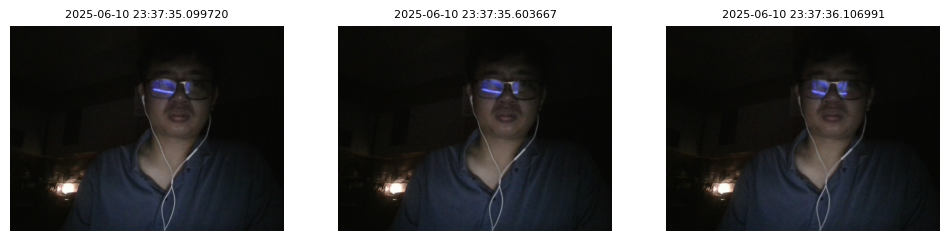

DEBUG:src.pipeline.inference:EdgeTPU init error: FileNotFoundError("Could not find module 'libedgetpu.so.1.0' (or one of its dependencies). Try using the full path with constructor syntax.")
DEBUG:src.pipeline.inference:EdgeTPU not available. Will use TFLite CPU runtime.
DEBUG:src.pipeline.pose_base:Initializing PoseEngine with confidence threshold             0.6
DEBUG:src.pipeline.fall_detect:Initializing FallDetector with conficence threshold:                   0.6
DEBUG:src.pipeline.fall_detect:FallDetector received new sample
DEBUG:src.pipeline.fall_detect:Calling TF engine for inference


Time after plotting: 2025-06-10 23:37:36.237202
Time before detecting: %s 2025-06-10 23:37:36.253631


DEBUG:src.pipeline.pose_base:input image size = (640, 480)
DEBUG:src.pipeline.pose_base:thmubnail image size = (257, 193)
DEBUG:src.pipeline.pose_base:input image size = (257, 193)
DEBUG:src.pipeline.pose_base:new image size = (257, 257)
DEBUG:src.pipeline.pose_engine:Overall pose score (keypoint score average): 0.4117647058823529
DEBUG:src.pipeline.pose_engine:Detected a pose with 7 keypoints that score over                 the minimum confidence threshold of                 0.6.
DEBUG:src.pipeline.pose_engine:Debug image saved: tmp-pose-detect-image-time-1505812546-keypoints-7.jpg
DEBUG:src.pipeline.fall_detect:Estimated spinal vector score: 0
DEBUG:src.pipeline.pose_base:input image size = (480, 640)
DEBUG:src.pipeline.pose_base:thmubnail image size = (193, 257)
DEBUG:src.pipeline.pose_base:input image size = (193, 257)
DEBUG:src.pipeline.pose_base:new image size = (257, 257)
DEBUG:src.pipeline.pose_engine:Overall pose score (keypoint score average): 0.17647058823529413
DEBUG:src.pi

Time after detecting: %s 2025-06-10 23:37:36.368407
Time before detecting: %s 2025-06-10 23:37:36.368407


DEBUG:src.pipeline.pose_engine:Detected a pose with 3 keypoints that score over                 the minimum confidence threshold of                 0.6.
DEBUG:src.pipeline.pose_engine:Debug image saved: tmp-pose-detect-image-time-1505812656-keypoints-3.jpg
DEBUG:src.pipeline.fall_detect:Estimated spinal vector score: 0
DEBUG:src.pipeline.pose_base:input image size = (480, 640)
DEBUG:src.pipeline.pose_base:thmubnail image size = (193, 257)
DEBUG:src.pipeline.pose_base:input image size = (193, 257)
DEBUG:src.pipeline.pose_base:new image size = (257, 257)
DEBUG:src.pipeline.pose_engine:Overall pose score (keypoint score average): 0.11764705882352941
DEBUG:src.pipeline.pose_engine:Detected a pose with 2 keypoints that score over                 the minimum confidence threshold of                 0.6.
DEBUG:src.pipeline.pose_engine:Debug image saved: tmp-pose-detect-image-time-1505812687-keypoints-2.jpg
DEBUG:src.pipeline.fall_detect:Estimated spinal vector score: 0
DEBUG:src.pipeline.fall_

Time after detecting: %s 2025-06-10 23:37:36.450027
Time before detecting: %s 2025-06-10 23:37:36.452023


DEBUG:src.pipeline.fall_detect:Estimated spinal vector score: 0
DEBUG:src.pipeline.pose_base:input image size = (480, 640)
DEBUG:src.pipeline.pose_base:thmubnail image size = (193, 257)
DEBUG:src.pipeline.pose_base:input image size = (193, 257)
DEBUG:src.pipeline.pose_base:new image size = (257, 257)
DEBUG:src.pipeline.pose_engine:Overall pose score (keypoint score average): 0.11764705882352941
DEBUG:src.pipeline.pose_engine:Detected a pose with 2 keypoints that score over                 the minimum confidence threshold of                 0.6.
DEBUG:src.pipeline.pose_engine:Debug image saved: tmp-pose-detect-image-time-1505812812-keypoints-2.jpg
DEBUG:src.pipeline.fall_detect:Estimated spinal vector score: 0
DEBUG:src.pipeline.fall_detect:No pose detected or detection score does not meet                     confidence threshold of 0.6.
DEBUG:src.pipeline.fall_detect:thumbnail: <PIL.Image.Image image mode=RGB size=257x193 at 0x1AF0BEB1050>


Time after detecting: %s 2025-06-10 23:37:36.585488
Time after predicting: 2025-06-10 23:37:36.586498
There is no fall detection...
Waiting for frames...


In [3]:
# %pip install tensorflow
# %pip install Pillow
# %pip install matplotlib
# %pip install opencv-python
# %pip install vonage
# %pip install python-dotenv

import cv2
from PIL import Image
from fall_prediction import Fall_prediction
import matplotlib.pyplot as plt
import requests
import datetime
from dotenv import load_dotenv
import os
import threading
import queue
import time

frame_queue = queue.Queue(maxsize=100)  # Limit queue size to avoid memory issues

def capture_camera():
    print("Starting camera capture...")
    cap = cv2.VideoCapture(0)
    n = 0
    while True:
        ret, frame = cap.read()
        n += 1
        if not ret or n > 10: # Break after 10 frame for demo
            break
        record_time = datetime.datetime.now()
        # Convert OpenCV BGR image to PIL Image
        pil_img = Image.fromarray(cv2.cvtColor(frame, cv2.COLOR_BGR2RGB))
        frame_queue.put((pil_img, record_time))
        time.sleep(0.5)  # Sleep for 0.5 seconds to control capture rate
    cap.release()
    frame_queue.put(None)  # Sentinel to signal end

def handle_frame():
    frame_buffer = []
    while True:
        print("Waiting for frames...")
        item = frame_queue.get()
        if item is None:
            break  # Exit loop if sentinel received 
        pil_img, record_time = item
        
        frame_buffer.append({
            'record_time': record_time,
            'img': pil_img
        })
    
        # Keep only the last 3 frames
        if len(frame_buffer) > 3:
            frame_buffer.pop(0)

        # Run prediction when we have 3 frames
        if len(frame_buffer) == 3:
            print("Time before plotting:", datetime.datetime.now())
            fig = plt.figure(figsize=(12,12))
            for idx, item in enumerate(frame_buffer):
                no = idx+1
                fig.add_subplot(1, 3, no)
                plt.imshow(item['img'])
                plt.title(item['record_time'], fontsize=8)
                plt.axis("off")
            plt.show()
            print("Time after plotting:", datetime.datetime.now())

            img_list = [item['img'] for item in frame_buffer]
            response = Fall_prediction(*img_list)
            print("Time after predicting:", datetime.datetime.now())
            if response:
                print("There is", response['category'])
                print("Confidence :", response['confidence'])
                print("Angle :", response['angle'])
                print("Keypoint_corr :", response['keypoint_corr'])

                # Call /record_fall API
                try:
                    api_response = requests.post(
                        f"{os.getenv('SIGNAL_SERVER_URL')}/record_fall",
                        json={
                            "source": "camera",
                            "patient_id": 1,
                            "detected_at": datetime.datetime.now().isoformat()
                        }
                    )
                    print("API response:", api_response.json())
                except Exception as e:
                    print("Failed to call /record_fall:", e)
            else:
                print("There is no fall detection...")

# Start threads
capture_thread = threading.Thread(target=capture_camera)
handle_thread = threading.Thread(target=handle_frame)

capture_thread.start()
handle_thread.start()

capture_thread.join()
handle_thread.join()